In [1]:
import sys
sys.path.append('./src')
import json
import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from backbones import OGBEmbedCINpp
from utils import get_data_loaders, set_seed, init_metric_dict, update_and_save_best_epoch_res, ExtractorMLP, get_optimizer, load_checkpoint
from trainer import run_one_epoch, get_viz_idx, visualize_results
from datetime import datetime
from torch.nn import functional as F
from baselines import LRIBern


/home/godfrey/anaconda3/envs/topo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using /home/godfrey/.cache/torch_extensions/py310_cu116 as PyTorch extensions root...
Emitting ninja build file /home/godfrey/.cache/torch_extensions/py310_cu116/pershom_cuda_ext/build.ninja...
Building extension module pershom_cuda_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module pershom_cuda_ext...


In [2]:
# dataset_name = 'ba_2motifs'
dataset_name = 'mutag'
# dataset_name = 'ogbg_molhiv'
model_name = 'cinpp'

method_name = 'lri_bern'
cuda_id = 1
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

model_config = {'num_layers': 3, 'emb_dim': 64, 'nonlinearity': 'relu', 'drop_rate': 0.15, 'readout': 'sum', 'final_readout':'sum', 'drop_position':'lin2',
                'graph_norm':'bn', 'atom_encoder':False}   
data_config = {'data_name': dataset_name, 'data_dir': '../data', 'max_ring_size': 5, 'include_down_adj': True, 'init_method': 'sum', 'n_jobs': 32}

method_config = {
    "one_encoder": True,
    "attn_constraint": "none",
    "temperature": 1.0,
    "decay_interval": 10,
    "decay_r": 0.1,
    "init_r": 0.8,
    "pred_loss_coef": 1.0,
    "pred_lr": 1.0e-3,
    "pred_wd": 1.0e-5,
    "dropout_p": 0.2,
    "norm_type": "batch",
    "act_type": "relu",
    'info_loss_coef': 0.1,
    'final_r': 0.7
}

optimizer_config = {
    "batch_size": 128,
    "wp_lr": 1.0e-3,
    "wp_wd": 1.0e-5,
    "attn_lr": 1.0e-3,
    "attn_wd": 1.0e-5,
    "emb_lr": 1.0e-3,
    "emb_wd": 1.0e-5
}

    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [4]:
loaders, dataset, test_set, x_dim, edge_attr_dim = get_data_loaders(dataset_name, batch_size=128, data_config=data_config)
# model_config['deg'] = aux_info['deg']

Processing cell complex dataset for mutag


Processing...


Converting the mutag dataset to a cell complex...
[INFO] Split dataset!
[INFO] mutag to explain !


100%|██████████| 2951/2951 [00:09<00:00, 309.84it/s]


Saving processed dataset in ../data/mutag/cell_complex_dim2_sum_5rings-E/mutag_complex.pt...
Saving idx in ../data/mutag/cell_complex_dim2_sum_5rings-E/mutag_idx.pt...
Loading dataset from disk...


Done!


Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: node_type
Using extra_attr: no

In [5]:
# count = (test_set.data['labels']==1).sum().item()
print(test_set.data.keys())

dict_keys(['labels', 'dims', 0, 1, 2, 'node_type'])


In [6]:
# for data in loaders['train']:
#     print(data.edge_label.shape)
#     print(data.cochains[0].upper_index.shape)
#     print(data.cochains[1].x.size(0))
#     print(data.cochains[0].batch)
#     print(data.cochains[1].boundary_index.shape)
#     second_row = data.cochains[1].boundary_index[1]
#     res = {}
#     for i in range(second_row.shape[0]):
#         key = second_row[i].item()
#         if key not in res:
#             res[key] = []
#         res[key].append(data.cochains[1].boundary_index[:,i])
#     new_index = {}
#     for k,v in res.items():
#         assert len(v) == 2
#         key1 = (v[0][0].item(), v[1][0].item())
#         new_index[key1] = k
#         key2 = (v[1][0].item(), v[0][0].item())
#         new_index[key2] = k
#     edges = data.cochains[0].upper_index
#     batch_attn = []
#     for e in range(edges.shape[1]):
#         edge = (edges[0][e].item(), edges[1][e].item())
#         batch_attn.append(new_index[edge])
#     print(len(batch_attn))
#     break

In [5]:
clf = OGBEmbedCINpp(x_dim,
                    edge_attr_dim,
                    1,                       # out_size
                    model_config['num_layers'],                         # num_layers
                    model_config['emb_dim'],                            # hidden
                    dropout_rate=model_config['drop_rate'],             # dropout_rate
                    indropout_rate=0.0,         # in-dropout_rate
                    max_dim=dataset.max_dim,                 # max_dim
                    jump_mode=None,                # jump_mode
                    nonlinearity=model_config['nonlinearity'],          # nonlinearity
                    readout=model_config['readout'],                    # readout
                    final_readout=model_config['final_readout'],        # final readout
                    apply_dropout_before=model_config['drop_position'], # where to apply dropout
                    use_coboundaries=True,       # whether to use coboundaries
                    embed_edge=True,       # whether to use edge feats
                    graph_norm=model_config['graph_norm'],              # normalization layer
                    readout_dims=(0, 1, 2),              # readout_dims
                    atom_encoder=model_config["atom_encoder"]
                    ).to(device)

extractor = ExtractorMLP(model_config['emb_dim'], method_config)
extractor = extractor.to(device)
criterion = F.binary_cross_entropy_with_logits
baseline = LRIBern(clf, extractor, criterion, method_config)
optimizer = get_optimizer(clf, extractor, optimizer_config, method_config, warmup=False, slayer= baseline.readout)

In [6]:
warmup = 0
writer = None
topk = 1
report_dict = None
for epoch in range(3):
    train_res = run_one_epoch(baseline, optimizer, loaders['train'], epoch, 'train', warmup, seed, device, writer, method_name)
    valid_res = run_one_epoch(baseline, None, loaders['valid'], epoch, 'valid', warmup, seed, device, writer, method_name)
    test_res = run_one_epoch(baseline, None, loaders['test'], epoch, 'test', warmup, seed, device, writer, method_name)
    
    metric_dict = update_and_save_best_epoch_res(baseline, train_res, valid_res, test_res, metric_dict, epoch, model_dir, seed, topk, False, writer)
    report_dict = {k.replace('metric/best_', ''): v for k, v in metric_dict.items()}  # for better readability
print(json.dumps(report_dict, indent=4))

[Seed 0, Epoch: 0]: train done, loss: 0.056, pred: 0.629, v_info: 0.283, e_info: 0.288, c_info: 0.287, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.183, org_acc: 0.716, msk_acc: 0.737, org_auc: 0.771, msk_auc: 0.778, exp_auc: 0.417, bkg_attn: 0.485, sig_attn: 0.400, : 100%|██████████| 19/19 [00:40<00:00,  2.13s/it]
[Seed 0, Epoch: 0]: valid done, loss: -0.189, pred: 0.416, v_info: 0.272, e_info: 0.207, c_info: 0.155, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.376, org_acc: 0.821, msk_acc: 0.839, org_auc: 0.887, msk_auc: 0.883, exp_auc: 0.293, bkg_attn: 0.515, sig_attn: 0.485, : 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]
[Seed 0, Epoch: 0]: test  done, loss: 0.031, pred: 0.634, v_info: 0.266, e_info: 0.222, c_info: 0.165, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.376, org_acc: 0.833, msk_acc: 0.767, msk_auc: 0.000, exp_auc: 0.410, bkg_attn: 0.505, sig_attn: 0.485, : 100%|██████████| 8/8 [00:13<00:00,  1.68s/it]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred Loss: 0.416, Best Val Pred AUROC: 0.293, Best Test Pred AUROC: 0.410, Best Test X AUROC: 0.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 1]: train done, loss: -0.257, pred: 0.378, v_info: 0.136, e_info: 0.151, c_info: 0.134, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.552, org_acc: 0.836, msk_acc: 0.847, org_auc: 0.907, msk_auc: 0.909, exp_auc: 0.457, bkg_attn: 0.558, sig_attn: 0.515, : 100%|██████████| 19/19 [00:38<00:00,  2.04s/it]
[Seed 0, Epoch: 1]: valid done, loss: -0.246, pred: 0.408, v_info: 0.148, e_info: 0.100, c_info: 0.087, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.748, org_acc: 0.866, msk_acc: 0.870, org_auc: 0.912, msk_auc: 0.905, exp_auc: 0.228, bkg_attn: 0.614, sig_attn: 0.593, : 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]
[Seed 0, Epoch: 1]: test  done, loss: 0.045, pred: 0.698, v_info: 0.144, e_info: 0.106, c_info: 0.097, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.748, org_acc: 0.851, msk_acc: 0.771, msk_auc: 0.000, exp_auc: 0.306, bkg_attn: 0.607, sig_attn: 0.593, : 100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred Loss: 0.416, Best Val Pred AUROC: 0.293, Best Test Pred AUROC: 0.410, Best Test X AUROC: 0.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


[Seed 0, Epoch: 2]: train done, loss: -0.347, pred: 0.331, v_info: 0.059, e_info: 0.075, c_info: 0.051, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -13.926, org_acc: 0.857, msk_acc: 0.858, org_auc: 0.924, msk_auc: 0.925, exp_auc: 0.470, bkg_attn: 0.619, sig_attn: 0.590, : 100%|██████████| 19/19 [00:38<00:00,  2.02s/it]
[Seed 0, Epoch: 2]: valid done, loss: -0.340, pred: 0.344, v_info: 0.120, e_info: 0.072, c_info: 0.037, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -14.125, org_acc: 0.875, msk_acc: 0.885, org_auc: 0.944, msk_auc: 0.926, exp_auc: 0.254, bkg_attn: 0.646, sig_attn: 0.634, : 100%|██████████| 5/5 [00:07<00:00,  1.54s/it]
[Seed 0, Epoch: 2]: test  done, loss: -0.249, pred: 0.434, v_info: 0.121, e_info: 0.077, c_info: 0.042, r0: 0.800, r1: 0.800, r2: 0.800, tpl: -14.125, org_acc: 0.967, msk_acc: 0.855, msk_auc: 0.000, exp_auc: 0.322, bkg_attn: 0.638, sig_attn: 0.634, : 100%|██████████| 8/8 [00:12<00:00,  1.57s/it]

[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred Loss: 0.416, Best Val Pred AUROC: 0.293, Best Test Pred AUROC: 0.410, Best Test X AUROC: 0.000, 
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
{
    "clf_epoch": 0,
    "clf_valid_loss": 0.4163585424423218,
    "clf_train": 0.4166754046911989,
    "clf_valid": 0.2930555138924936,
    "clf_test": 0.40986530338278093,
    "x_roc_train": 0.7777306789557823,
    "x_roc_valid": 0.8834859949555292,
    "x_roc_test": 0
}


In [7]:
# best_epoch = report_dict['clf_epoch']
load_checkpoint(baseline, model_dir, model_name='model', map_location=device)

In [9]:
num_viz_samples = 10

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)

In [12]:
# print(test_set[0].node_type)
print(dataset[0].keys)

['dimension', 'cochains', 'nodes', 'edges', 'edges_attr', 'node_label', 'edge_label', 'two_cells', 'y']


  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'Complex' object has no attribute 'node_type'

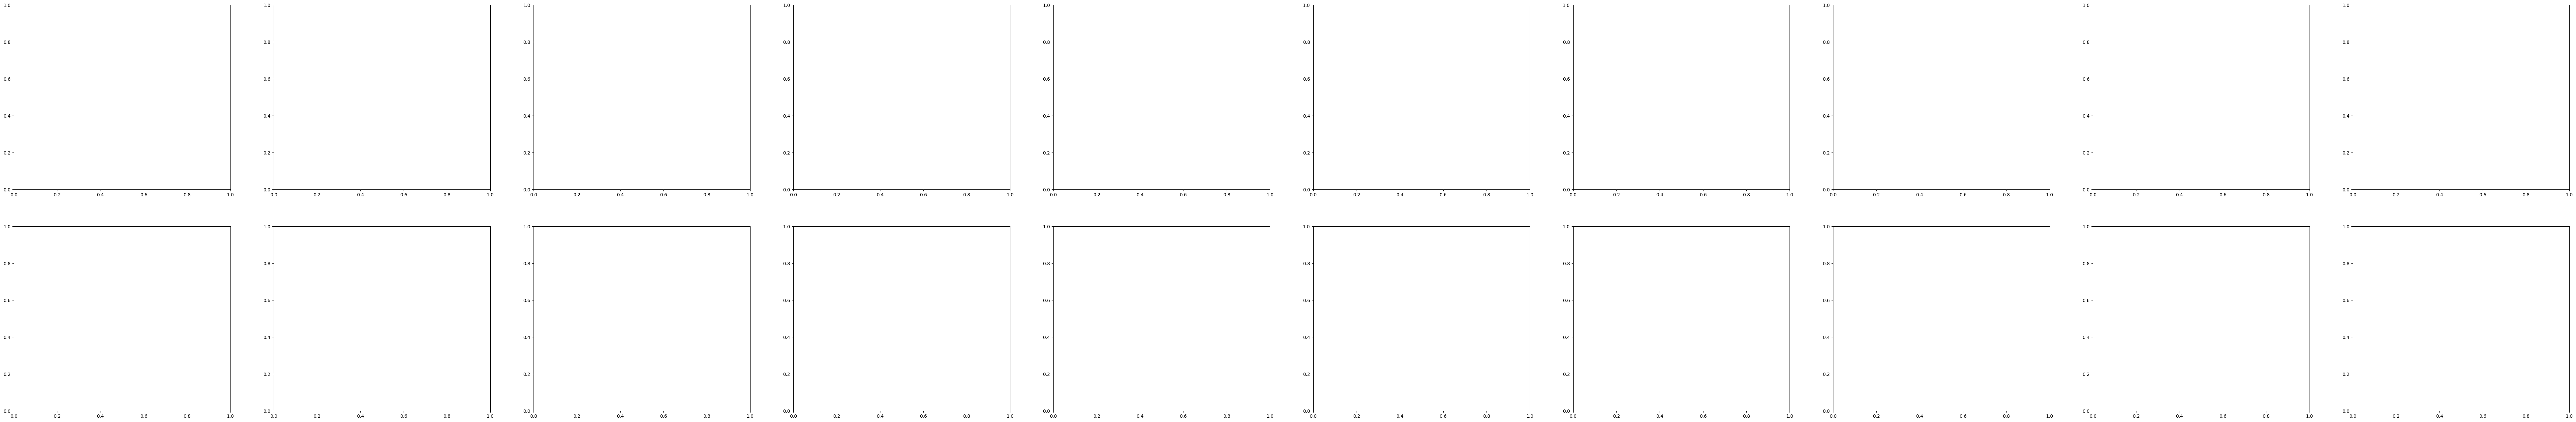

In [8]:

visualize_results(baseline, all_viz_set, test_set, num_viz_samples, dataset_name, None, method_name)
#gsat, all_viz_set, test_set, num_viz_samples, dataset_name, optimizer, method_name